In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset loading

In [2]:
dataset = pd.read_csv('../Y3 - Sample data/Z2 - datasetprepclean.csv', index_col = 0,
                     )
print('dataset shape:', dataset.shape)
dataset.head()

dataset shape: (4659, 281)


,cut_length,num_closed_patterns,num_open_patterns,total_area,minimum_rectangle_area,minimum_rectangle_dim1,minimum_rectangle_dim2,convex_hull_area,no_hole_area,thickness,...,bend_edge_length_std_09,bend_edge_length_min_09,bend_edge_length_max_09,VAMAT,VALAJOUT,VALTOT,VOL_COST_CONVHULL,VOL_COST_RECTANGLE,VOL_COST_MPATTERN,bend_group
COART,,,,,,,,,,,,,,,,,,,,,
L1600360,3178.489502,9,0,285678.093750,431798.46875,722.070984,598.000000,320484.593750,286893.718750,4.0,...,0.0,0.0,0.0,12.51,5.15,17.66,0.000010,0.000007,0.000011,3-5
L1600470,317.114502,1,0,3403.138184,3500.00000,140.000000,25.000000,3403.138184,3403.138184,10.0,...,0.0,0.0,0.0,0.25,0.92,1.17,0.000007,0.000007,0.000007,0
L1600700,625.429871,2,0,10823.929688,12759.00000,255.179993,50.000000,11152.315430,11152.315430,10.0,...,0.0,0.0,0.0,0.75,1.61,2.36,0.000007,0.000006,0.000007,1-2
L1600710,625.429871,2,0,10823.929688,12759.00000,255.179993,50.000000,11152.315430,11152.315430,10.0,...,0.0,0.0,0.0,0.75,1.61,2.36,0.000007,0.000006,0.000007,1-2
L1605790,2535.909668,5,0,184134.328125,355747.34375,826.389404,430.483917,230244.703125,184672.265625,5.0,...,0.0,0.0,0.0,12.24,5.72,17.96,0.000011,0.000007,0.000013,3-5


In [3]:
dataset.columns.values

array(['cut_length', 'num_closed_patterns', 'num_open_patterns',
       'total_area', 'minimum_rectangle_area', 'minimum_rectangle_dim1',
       'minimum_rectangle_dim2', 'convex_hull_area', 'no_hole_area',
       'thickness', 'radius_approx', 'radius_count', 'direction_count',
       'bend_count', 'bend_radius_00', 'bend_angle_00',
       'bend_direction_00', 'deformation_length_00', 'merged_bend_00',
       'punch_length_00', 'bend_radius_01', 'bend_angle_01',
       'bend_direction_01', 'deformation_length_01', 'merged_bend_01',
       'punch_length_01', 'bend_radius_02', 'bend_angle_02',
       'bend_direction_02', 'deformation_length_02', 'merged_bend_02',
       'punch_length_02', 'bend_radius_03', 'bend_angle_03',
       'bend_direction_03', 'deformation_length_03', 'merged_bend_03',
       'punch_length_03', 'bend_radius_04', 'bend_angle_04',
       'bend_direction_04', 'deformation_length_04', 'merged_bend_04',
       'punch_length_04', 'bend_radius_05', 'bend_angle_05',
     

In [4]:
for index, nancount in dataset.isnull().sum().iteritems():
    if nancount != 0:
        print(index, '-->', nancount)
else:
    print('Done !')

deformation_length_00 --> 240
deformation_length_01 --> 113
deformation_length_02 --> 10
deformation_length_03 --> 3
deformation_length_04 --> 1
deformation_length_05 --> 1
Done !


In [5]:
#Cleaning of the remaining Nan
dataset = dataset.dropna()
dataset.shape

(4389, 281)

# cleaning to have at least min occurences

In [6]:
minocc = 50
todrop = []
df = dataset['thickness'].reset_index().groupby('thickness').count()
for index, occ in df.iterrows():
    if occ.COART <= minocc:
        todrop.append(index)

for thickness in todrop:
    dataset = dataset[dataset['thickness'] != thickness]
dataset.shape

(4356, 281)

# Dataset re-ordering and Splitting

The baseline will be defined with the 3 core factors:
- Thickness
- Area
- Number of bends

In [7]:
start = dataset.columns.values
todrop = ['bend_group', 'VAMAT', 'VALAJOUT', 'VALTOT', 'radius_approx', 'level_0']

def representsInt(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False
benddetails  = [x for x in dataset.columns.values if representsInt(x[-2:])]
#todrop.extend(benddetails)

todrop.extend([x for x in dataset.columns.values if x.startswith('VOL_')])

tokeep = [x for x in start if x not in todrop ]
tokeep

['cut_length',
 'num_closed_patterns',
 'num_open_patterns',
 'total_area',
 'minimum_rectangle_area',
 'minimum_rectangle_dim1',
 'minimum_rectangle_dim2',
 'convex_hull_area',
 'no_hole_area',
 'thickness',
 'radius_count',
 'direction_count',
 'bend_count',
 'bend_radius_00',
 'bend_angle_00',
 'bend_direction_00',
 'deformation_length_00',
 'merged_bend_00',
 'punch_length_00',
 'bend_radius_01',
 'bend_angle_01',
 'bend_direction_01',
 'deformation_length_01',
 'merged_bend_01',
 'punch_length_01',
 'bend_radius_02',
 'bend_angle_02',
 'bend_direction_02',
 'deformation_length_02',
 'merged_bend_02',
 'punch_length_02',
 'bend_radius_03',
 'bend_angle_03',
 'bend_direction_03',
 'deformation_length_03',
 'merged_bend_03',
 'punch_length_03',
 'bend_radius_04',
 'bend_angle_04',
 'bend_direction_04',
 'deformation_length_04',
 'merged_bend_04',
 'punch_length_04',
 'bend_radius_05',
 'bend_angle_05',
 'bend_direction_05',
 'deformation_length_05',
 'merged_bend_05',
 'punch_length_

In [8]:
#Dataset definition
X = dataset[['thickness', 'minimum_rectangle_area', 'bend_count']]
y = dataset[['VAMAT', 'VALAJOUT', 'VALTOT']]

limitedset = ['thickness', 'minimum_rectangle_area', 'bend_count']


In [9]:
target = 'VALTOT'
assert target in y.columns.values, 'The target must be in y dataset'

In [10]:
y[[target]].describe()

,VALTOT
count,4356.000000
mean,8.909522
std,12.568147
min,0.320000
25%,2.537500
50%,4.605000
75%,10.100000
max,145.410000


In [11]:
# Dataset splitting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=0 ,stratify=dataset['bend_group'])

# Blocs creation

In [12]:
#Scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [13]:
# Metric
from sklearn.metrics import mean_squared_error

In [14]:
# Metric MAPE Mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

from sklearn.metrics import make_scorer
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
mape_scorer

make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [73]:
#regressions
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0, random_state=0, normalize=False, fit_intercept=False)

from sklearn.linear_model import ElasticNet
enet = ElasticNet(alpha=0, l1_ratio=1, random_state=0, normalize=False, fit_intercept=False)

from sklearn.linear_model import LinearRegression
linreg = LinearRegression(normalize=False, fit_intercept=False)

In [74]:
#Other tools
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# No standardisation

In [75]:
parameters = {'alpha':np.logspace(-3,3,11),
              'l1_ratio':np.linspace(0.01,1,11)
             }
regnostd = GridSearchCV(enet, parameters, cv=5, n_jobs=-2, scoring='neg_mean_squared_error')

In [76]:
regnostd.fit(X_train[limitedset], y_train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=ElasticNet(alpha=0, copy_X=True, fit_intercept=False, l1_ratio=1,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'alpha': array([1.00000e-03, 3.98107e-03, 1.58489e-02, 6.30957e-02, 2.51189e-01,
       1.00000e+00, 3.98107e+00, 1.58489e+01, 6.30957e+01, 2.51189e+02,
       1.00000e+03]), 'l1_ratio': array([0.01 , 0.109, 0.208, 0.307, 0.406, 0.505, 0.604, 0.703, 0.802,
       0.901, 1.   ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [19]:
regnostd.best_params_

{'alpha': 0.25118864315095796, 'l1_ratio': 0.01}

In [77]:
regnostd.score(X_train[limitedset], y_train[target])

-27.801924211208078

In [78]:
regnostd.score(X_test[limitedset], y_test[target])

-23.06083482076702

In [79]:
mean_squared_error(y_test[target], regnostd.predict(X_test[limitedset]))

23.06083482076702

In [80]:
regnostd.best_estimator_.coef_

array([ 4.42951013e-01,  5.76516086e-05, -2.92970602e-01])

In [81]:
regnostd.predict(np.array([10.0, 123061.765625, 2]).reshape(1,-1))

array([10.93827767])

In [82]:
(np.array([10.0, 123061.765625, 2]) * regnostd.best_estimator_.coef_).sum()

10.938277668316271

# Linear regression

In [26]:
parameters = {}
reglinnostd = GridSearchCV(linreg, parameters, cv=5, n_jobs=-2, scoring='neg_mean_squared_error')

In [27]:
reglinnostd.fit(X_train[limitedset], y_train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False),
       fit_params=None, iid=True, n_jobs=-2, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [28]:
reglinnostd.score(X_test[limitedset], y_test[target])

-23.09064579150321

In [29]:
mean_squared_error(y_test[target], reglinnostd.predict(X_test[limitedset]))

23.09064579150321

In [30]:
reglinnostd.best_estimator_.coef_

array([ 4.48517517e-01,  5.77472725e-05, -3.35387543e-01])

In [31]:
reglinnostd.predict(np.array([10.0, 123061.765625, 2]).reshape(1,-1))

array([10.92088139])

In [32]:
np.dot(np.array([10.0, 123061.765625, 2]), reglinnostd.best_estimator_.coef_)

10.920881393535339

In [33]:
reglinnostd.best_estimator_.intercept_

0.0

# Per thickness

In [34]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_X_y

In [41]:
class Regthick(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.thickness = []
    
    def fit(self, X, y):
        #X, y = check_X_y(X, y)
        self.thickness = X['thickness'].unique()
        parameters = {'alpha':np.logspace(-3,3,5),
                      'l1_ratio':np.linspace(0.01,1,5)
                        }
        for thickness in self.thickness:
            setattr(self, 'reg{:02d}'.format(int(thickness)),
                    GridSearchCV(ElasticNet(alpha=0, l1_ratio=1, random_state=0, normalize=False, fit_intercept=False),
                                 parameters, cv=3, n_jobs=-2, scoring='neg_mean_squared_error'))
            
            mask = X['thickness']==thickness
            #print(X.columns.values)
            df = X[mask]
            labels = y[mask]
            getattr(self, 'reg{:02d}'.format(int(thickness))).fit(df[['minimum_rectangle_area', 'bend_count']], labels)
    
    def predict(self, X, y=None):
        thickness = X[0]
        df = np.array(X[1:]).reshape(1, -1)
        return getattr(self, 'reg{:02d}'.format(int(thickness))).predict(df)
    
    def get_th_coefs(self):
        toreturn = []
        for th in self.thickness:
            temp = []
            estim = getattr(self, 'reg{:02d}'.format(int(th)))
            coeffs = estim.best_estimator_.coef_.copy()
            temp.append(th)
            temp.extend(coeffs.tolist())
            toreturn.append(temp)
        return np.array(toreturn)
    


In [42]:
regthick = Regthick()
regthick.fit(X_train[limitedset], y_train[target])

In [43]:
#regthick.reg10.predict(np.array([10.0, 123061.765625, 2]).reshape(1,-1))
regthick.predict([10.0, 123061.765625, 2])

array([14.57349556])

In [44]:
np.dot(regthick.reg10.best_estimator_.coef_, [123061.765625, 2])

14.573495560636196

In [45]:
#1.26214574e-05 * 123061.765625 + 6.96330034e-01*2
regthick.get_th_coefs()

array([[8.00000000e+00, 7.73430572e-05, 9.86797803e-01],
       [5.00000000e+00, 5.04518142e-05, 8.69758812e-01],
       [6.00000000e+00, 6.02140407e-05, 2.87956395e-01],
       [4.00000000e+00, 4.19823613e-05, 4.80366227e-01],
       [1.20000000e+01, 1.14778482e-04, 0.00000000e+00],
       [1.50000000e+01, 1.41079285e-04, 0.00000000e+00],
       [1.00000000e+01, 1.00780836e-04, 1.08561399e+00],
       [3.00000000e+00, 3.71596408e-05, 4.54865006e-01]])

In [50]:
df = pd.DataFrame(regthick.get_th_coefs())
df.columns=['thickness', 'K1', 'K2']
df.set_index('thickness', inplace=True)
df.sort_index()

,K1,K2
thickness,,
3.0,0.000037,0.454865
4.0,0.000042,0.480366
5.0,0.000050,0.869759
6.0,0.000060,0.287956
8.0,0.000077,0.986798
10.0,0.000101,1.085614
12.0,0.000115,0.000000
15.0,0.000141,0.000000


In [51]:
asmset = [[th, rect, bend] for th, rect, bend in zip(X_test.thickness.tolist(),
                                            X_test.minimum_rectangle_area.tolist(),
                                           X_test.bend_count.tolist(),)]

# Results comparison

In [54]:
prediction_s2 = np.array([regthick.predict(x)[0] for x in asmset])
prediction_s1 = regnostd.predict(X_test[limitedset])

In [55]:
resultset = pd.DataFrame({target: y_test[target],
                          'pred_S1':prediction_s1,
                          'pred_S2':prediction_s2}, index=y_test.index)
resultset.head()

,VALTOT,pred_S1,pred_S2
COART,,,
L3108232,3.43,3.779595,3.621699
L7046980,1.94,2.650657,0.586586
L2605660,2.18,2.353234,0.869892
L6019100,9.58,10.603595,9.486956
L6706110,1.85,4.131870,0.789188


In [56]:
mean_squared_error(resultset[target], resultset['pred_S1'])

23.06083482076702

In [57]:
mean_squared_error(resultset[target], resultset['pred_S2'])

8.959651500433194

In [60]:
resultset['MSE_s1'] = (resultset[target]-resultset['pred_S1'])**2
resultset['MSE_s2'] = (resultset[target]-resultset['pred_S2'])**2
resultset.head()

,VALTOT,pred_S1,pred_S2,MSE_s1,MSE_s2
COART,,,,,
L3108232,3.43,3.779595,3.621699,0.122217,0.036749
L7046980,1.94,2.650657,0.586586,0.505033,1.831729
L2605660,2.18,2.353234,0.869892,0.030010,1.716382
L6019100,9.58,10.603595,9.486956,1.047747,0.008657
L6706110,1.85,4.131870,0.789188,5.206931,1.125321


In [61]:
#
comparisonset = pd.merge(resultset.reset_index(), X_test.reset_index(), on='COART', how='inner')
comparisonset.head()

,COART,VALTOT,pred_S1,pred_S2,MSE_s1,MSE_s2,thickness,minimum_rectangle_area,bend_count
0,L3108232,3.43,3.779595,3.621699,0.122217,0.036749,5.0,37306.523438,2
1,L7046980,1.94,2.650657,0.586586,0.505033,1.831729,6.0,4959.472656,1
2,L2605660,2.18,2.353234,0.869892,0.030010,1.716382,6.0,4882.240234,2
3,L6019100,9.58,10.603595,9.486956,1.047747,0.008657,6.0,147989.453125,2
4,L6706110,1.85,4.131870,0.789188,5.206931,1.125321,8.0,10203.738281,0


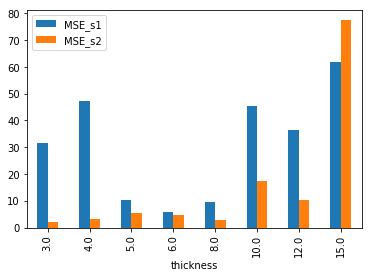

In [62]:
# Is the error sourced by thickness ?
df = comparisonset[['MSE_s1', 'MSE_s2', 'thickness']].groupby('thickness').mean()
df.plot.bar()
plt.show()


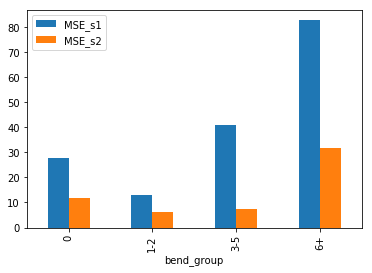

In [63]:
# Is the error sourced by number of errors ?

# Is the error sourced by number of errors ?
def bendgroupcalc(entry):
    if entry == 0:
        return '0'
    elif entry <= 2:
        return '1-2'
    elif entry <= 5:
        return '3-5'
    else:
        return '6+'
    return 'None'

comparisonset['bend_group'] = comparisonset['bend_count'].apply(bendgroupcalc)

df = comparisonset[['MSE_s1', 'MSE_s2', 'bend_group']].groupby('bend_group').mean()
df.plot.bar()
plt.show()


In [64]:
mean_absolute_percentage_error
comparisonset['MAPE_error_s1'] = comparisonset.apply(lambda x: mean_absolute_percentage_error(x[target], x['pred_S1']), axis=1)
comparisonset['MAPE_error_s2'] = comparisonset.apply(lambda x: mean_absolute_percentage_error(x[target], x['pred_S2']), axis=1)
comparisonset['percent_error_s1'] = ((comparisonset[target] / comparisonset['pred_S1'])-1)*100
comparisonset['percent_error_s2'] = ((comparisonset[target] / comparisonset['pred_S2'])-1)*100
comparisonset[[target, 'pred_S1', 'MAPE_error_s1', 'pred_S2', 'MAPE_error_s2']].head()

,VALTOT,pred_S1,MAPE_error_s1,pred_S2,MAPE_error_s2
0,3.43,3.779595,10.192273,3.621699,5.588904
1,1.94,2.650657,36.631807,0.586586,69.763594
2,2.18,2.353234,7.946508,0.869892,60.096688
3,9.58,10.603595,10.684707,9.486956,0.971234
4,1.85,4.131870,123.344326,0.789188,57.341172


In [65]:
mean_absolute_percentage_error(comparisonset[target], comparisonset['pred_S2'])

23.948454332243703

In [66]:
comparisonset['MAPE_error_s2'].mean()

23.94845433224368

In [67]:
comparisonset['percent_error_s2'].mean()

43.51657827044511

In [68]:
df = comparisonset[['MSE_s2', 'MAPE_error_s2', 'thickness', 'bend_group', 'COART']].groupby(['thickness', 'bend_group'])#.mean()
df.agg({'MSE_s2': ['mean', 'max'], 'MAPE_error_s2': ['mean', 'max'],'COART':['count'] })

MSE_s2              MAPE_error_s2             COART
                           mean          max          mean         max count
thickness bend_group                                                        
3.0       0            1.066765     4.495775     23.980855   60.580693     8
          1-2          1.523358     9.178677     16.502959   36.964275    12
          3-5          1.332707     5.817351     14.436704   46.652194    10
          6+           8.290345    11.554902     23.759130   38.848574     3
4.0       0            1.589987    15.492073     24.899233   76.317642    38
          1-2          1.694039    63.974974     18.072408   62.778200   124
          3-5          7.969906    86.133010     14.747081   57.359624    44
          6+           2.214076     3.831799     13.374624   21.071025     2
5.0       0            1.184241     7.839245     38.937726   83.472682    60
          1-2          5.161874   263.293674     18.730829  105.054029    95
          3-5         12.210255   122.136376      9.636976   26.620500    33
          6+          20.389060    67.683656     16.928100   47.942935     4
6.0       0            3.182441    85.431481     37.691460   94.503283   161
          1-2          3.459970   166.933794     30.633596   77.699453   172
          3-5          8.700443    69.066281     14.799467   42.474247    32
          6+          61.255929   319.166387     21.538210   28.547824     6
8.0       0            2.740545   102.947544     34.568145   84.130245   150
          1-2          2.928551   120.418195     12.071872   84.301786   123
          3-5          1.713573     7.722472     11.276648   33.284572    27
10.0      0           10.263867   291.544086     24.480522   88.415790    82
          1-2         26.575971   309.803183     14.144377   72.768226    81
          3-5          1.147936     2.040475      6.643624   14.414499     9
12.0      0           13.680872   761.886864     22.026986   86.002624    71
          1-2          3.457824    19.904559     14.099056   58.219961    31
          3-5          3.401783     6.003382     10.748952   18.312258     2
15.0      0           87.663105  3715.871166     24.275586   87.649107    50
          1-2          7.400117    47.960226     10.621895   26.625653     7
          3-5         51.540995    51.540995     30.000860   30.000860     1

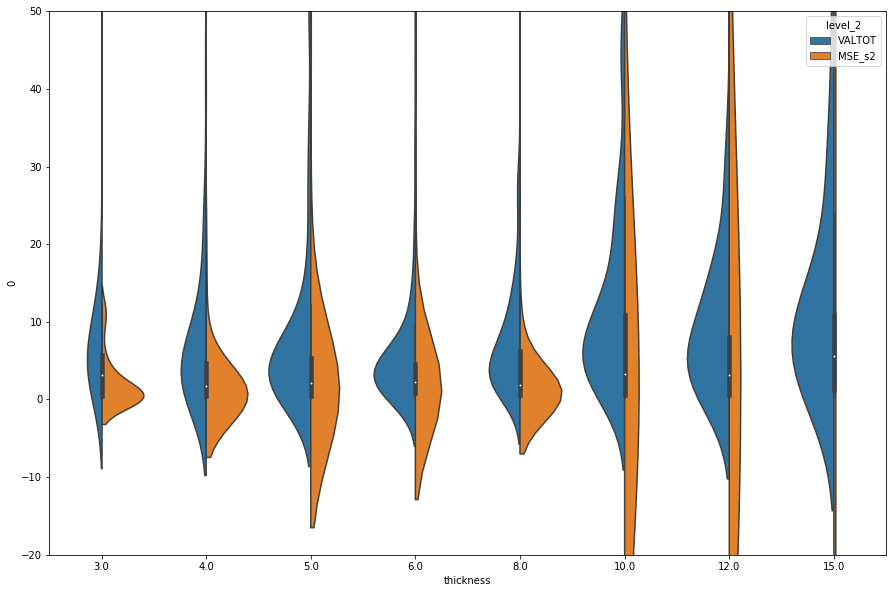

In [71]:
df=comparisonset[[target, 'MSE_s2', 'COART', 'thickness']]
#df=df[df['thickness']!=15]
df.set_index(['COART', 'thickness'], inplace=True)
df = df.stack().reset_index()
fig, ax = plt.subplots(figsize=(15,10))
ax.set_ylim(-20, 50)
sns.violinplot(x="thickness", y=0, data=df, split=True, hue='level_2', ax=ax)

plt.show()

In [72]:
df = comparisonset[['MSE_s2', 'COART', 'thickness']]
df.set_index('COART', inplace=True)
worst = df.groupby('thickness')['MSE_s2'].nlargest(3)
worst
#worst.to_csv('worst_s0.csv')

thickness  COART   
3.0        L7061530      11.554902
           L8033291      11.459347
           L8407220       9.178677
4.0        L8807311      86.133010
           L6703400      64.659738
           L1608640      63.974974
5.0        L8415700     263.293674
           L6704710     122.136376
           L8834210     110.887882
6.0        L3052760     319.166387
           L7017601     166.933794
           L7066120      85.599678
8.0        L2607600     120.418195
           L2607690     102.947544
           L7080610      67.161201
10.0       L3063340     309.803183
           L3059100     309.358105
           L3063330     306.993386
12.0       L3050120     761.886864
           L7047481      80.317851
           L2521480      22.689097
15.0       L3119180    3715.871166
           L8833300     248.912846
           L2512080     133.803507
Name: MSE_s2, dtype: float64